(conditional_autoregressive_priors)=
# Conditional Autoregressive (CAR) Models for Spatial Data

:::{post} Jul 29, 2022 
:tags: spatial, autoregressive, count data
:category: beginner, tutorial
:author: Conor Hassan, Daniel Saunders
:::

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

:::{include} ../extra_installs.md
:::

In [2]:
# THESE ARE THE LIBRARIES THAT ARE NOT DEPENDENCIES ON PYMC
import libpysal

from geopandas import read_file

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Conditional Autoregressive (CAR) model

A *conditional autoregressive CAR prior* on a set of random effects $\{\phi_i\}_{i=1}^N$ models the random effect $\phi_i$ as having a mean, that is the weighted average the random effects of observation $i$'s adjacent neighbours. Mathematically, this can be expressed as 

$$\phi_i \big | \mathbf{\phi}_{j\sim i} \sim \text{Normal} \bigg( \alpha \frac{ \sum_{j=1}^{n_i}w_{ij} \phi_j}{n_i}, \sigma_{i}^2\bigg)$$

where ${j \sim i}$ indicates the set of adjacent neighbours to observation $i$, $n_i$ denotes the number of adjacent neighbours that observation $i$ has, $w_{ij}$ is the weighting of the spatial relationship between observation $i$ and $j$. If $i$ and $j$ are not adjacent, then $w_{ij}=0$. Lastly, $\sigma_i^2$ is a spatially varying variance parameter for each area. Note that information such as an adjacency matrix, indicating the neighbour relationships, and a weight matrix $\textbf{w}$, indicating the weights of the spatial relationships, is required as input data. The parameters that we infer are $\{\phi\}_{i=1}^N, \{\sigma_i\}_{i=1}^N$, and $\alpha$. 

## Model specification 

Here we will demonstrate the implementation of a CAR model using a canonical example: the lip cancer risk data in Scotland between 1975 and 1980. The original data is from [1]. This dataset includes observed lip cancer case counts $\{y_i\}_{i=1}^N$ at $N=56$ spatial units in Scotland, with the expected number of cases $\{E_i\}_{i=1}^N$ as an offset term, an intercept parameter, and and a parameter for an area-specific continuous variable for the proportion of the population employed in agriculture, fishing, or forestry, denoted by $\{x_i\}_{i=1}^N$. We want to model how the lip cancer rates relate to the distribution of employment among industries, as exposure to sunlight is a risk factor. Mathematically, the model is 
\begin{align*} 
y_i &\sim \text{Poisson}\big (\lambda_i),\\
\log \lambda_i &= \beta_0+\beta_1x_i + \phi_i + \log E_i,\\
\phi_i \big | \mathbf{\phi}_{j\sim i}&\sim\text{Normal}\big(\alpha\sum_{j=1}^{n_i}w_{ij}\phi_j, \sigma_{i}^2\big ), \\
\beta_0, \beta_1 &\sim \text{Normal}\big (0, a\big ),
\end{align*}
where $a$ is the some chosen hyperparameter for the variance of the prior distribution of the regression coefficients. 

## Preparing the data 

We need to load in the dataset to access the variables $\{y_i, x_i, E_i\}_{i=1}^N$. But more unique to the use of CAR models, is the creation of the necessary spatial adjacency matrix. For the models that we fit, all neighbours are weighted as $1$, circumventing the need for a weight matrix.

In [4]:
try:
    df_scot_cancer = pd.read_csv(os.path.join("..", "data", "scotland_lips_cancer.csv"))
except FileNotFoundError:
    df_scot_cancer = pd.read_csv(pm.get_data("scotland_lips_cancer.csv"))

In [5]:
df_scot_cancer.head()

,CODENO,NAME,CANCER,CEXP,AFF,ADJ,WEIGHTS
0,6126,Skye-Lochalsh,9,1.38,16,"[5, 9, 11, 19]","[1, 1, 1, 1]"
1,6016,Banff-Buchan,39,8.66,16,"[7, 10]","[1, 1]"
2,6121,Caithness,11,3.04,10,"[6, 12]","[1, 1]"
3,5601,Berwickshire,9,2.53,24,"[18, 20, 28]","[1, 1, 1]"
4,6125,Ross-Cromarty,15,4.26,10,"[1, 11, 12, 13, 19]","[1, 1, 1, 1, 1]"


In [6]:
# observed cancer counts
y = df_scot_cancer["CANCER"].values

# number of observations
N = len(y)

# expected cancer counts E for each county: this is calculated using age-standardized rates of the local population
E = df_scot_cancer["CEXP"].values
logE = np.log(E)

In [7]:
# proportion of the population engaged in agriculture, forestry, or fishing
x = df_scot_cancer["AFF"].values / 10.0

Below are the steps that we take to create the necessary adjacency matrix, where the entry $i,j$ of the matrix is $1$ if observations $i$ and $j$ are considered neighbours, and $0$ otherwise.

In [8]:
# spatial adjacency information: column `ADJ` contains list entries which are preprocessed to obtain adj as a list of lists
adj = (
    df_scot_cancer["ADJ"].apply(lambda x: [int(val) for val in x.strip("][").split(",")]).to_list()
)

In [9]:
# change to Python indexing (i.e. -1)
for i in range(len(adj)):
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j] - 1

In [10]:
# storing the adjacency matrix as a two-dimensional np.array
adj_matrix = np.zeros((N, N), dtype="int32")

for area in range(N):
    adj_matrix[area, adj[area]] = 1

## Visualizing the data 

An important aspect of modelling spatial data is the ability to effectively visualize the spatial nature of the data, and whether the model that you have chosen captures this spatial dependency. 

We load in an alternate version of the *Scottish lip cancer* dataset, from the `libpysal` package, to use for plotting.

In [11]:
_ = libpysal.examples.load_example("Scotlip")
pth = libpysal.examples.get_path("scotlip.shp")
spat_df = read_file(pth)
spat_df["PROP"] = spat_df["CANCER"] / np.exp(spat_df["CEXP"])
spat_df.head()

,CODENO,AREA,PERIMETER,RECORD_ID,DISTRICT,NAME,CODE,CANCER,POP,CEXP,AFF,geometry,PROP
0,6126,9.740020e+08,184951.0,1,1,Skye-Lochalsh,w6126,9,28324,1.38,16,"POLYGON ((214091.875 841215.188, 218829.000 83...",2.264207
1,6016,1.461990e+09,178224.0,2,2,Banff-Buchan,w6016,39,231337,8.66,16,"POLYGON ((383866.000 865862.000, 398721.000 86...",0.006762
2,6121,1.753090e+09,179177.0,3,3,Caithness,w6121,11,83190,3.04,10,"POLYGON ((311487.000 968650.000, 320989.000 96...",0.526184
3,5601,8.985990e+08,128777.0,4,4,Berwickshire,w5601,9,51710,2.53,24,"POLYGON ((377180.000 672603.000, 386871.656 67...",0.716931
4,6125,5.109870e+09,580792.0,5,5,Ross-Cromarty,w6125,15,129271,4.26,10,"POLYGON ((278680.062 882371.812, 294960.000 88...",0.211835


We initially plot the observed number of cancer counts over the expected number of cancer counts for each area. The spatial dependency that we observe in this plot indicates that we may need to consider a spatial model for the data.

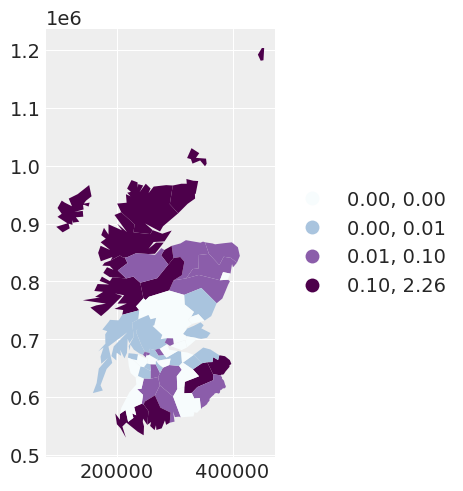

In [12]:
scotland_map = spat_df.plot(
    column="PROP",
    scheme="QUANTILES",
    k=4,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)},
)

## Writing some models in **PyMC**

### Our first model: an *independent* random effects model
We begin by fitting an independent random effect's model. We are not modelling any *spatial dependency* between the areas. This model is equivalent to a Poisson regression model with a normal random effect, and mathematically looks like
\begin{align*} 
y_i &\sim \text{Poisson}\big (\lambda_i),\\
\log \lambda_i &= \beta_0+\beta_1x_i + \theta_i + \log E_i,\\
\theta_i &\sim\text{Normal}\big(\mu=0, \tau=\tau_{\text{ind}}\big ), \\
\beta_0, \beta_1 &\sim \text{Normal}\big (\mu=0, \tau = 1e^{-5}\big ), \\
\tau_{\text{ind}} &\sim \text{Gamma}\big (\alpha=3.2761, \beta=1.81\big),
\end{align*} 
where $\tau_\text{ind}$ is an unknown parameter for the precision of the independent random effects. The values for the $\text{Gamma}$ prior are chosen specific to our second model and thus we will delay explaining our choice until then.

In [13]:
with pm.Model(coords={"area_idx": np.arange(N)}) as independent_model:
    beta0 = pm.Normal("beta0", mu=0.0, tau=1.0e-5)
    beta1 = pm.Normal("beta1", mu=0.0, tau=1.0e-5)
    # variance parameter of the independent random effect
    tau_ind = pm.Gamma("tau_ind", alpha=3.2761, beta=1.81)

    # independent random effect
    theta = pm.Normal("theta", mu=0, tau=tau_ind, dims="area_idx")

    # exponential of the linear predictor -> the mean of the likelihood
    mu = pm.Deterministic("mu", pt.exp(logE + beta0 + beta1 * x + theta), dims="area_idx")

    # likelihood of the observed data
    y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx")

    # saving the residual between the observation and the mean response for the area
    res = pm.Deterministic("res", y - mu, dims="area_idx")

    # sampling the model
    independent_idata = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_ind, theta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.


We can plot the residuals of this first model.

In [14]:
spat_df["INDEPENDENT_RES"] = independent_idata["posterior"]["res"].mean(dim=["chain", "draw"])

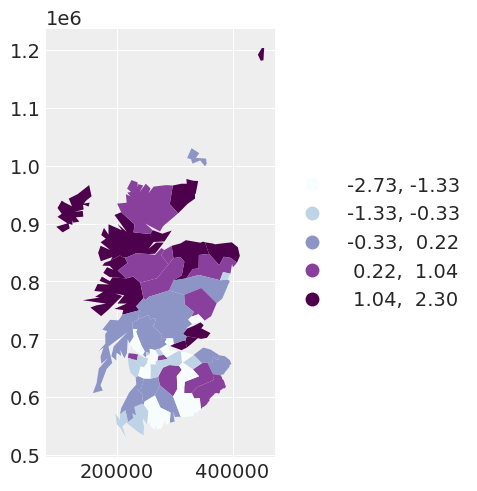

In [15]:
independent_map = spat_df.plot(
    column="INDEPENDENT_RES",
    scheme="QUANTILES",
    k=5,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)},
)

The mean of the residuals for the areas appear spatially correlated. This leads us to explore the addition of a spatially dependent random effect, by using a **conditional autoregressive (CAR)** prior.

### Our second model: a *spatial* random effects model (with fixed spatial dependence)
Let us fit a model that has two random effects for each area: an *independent* random effect, and a *spatial* random effect first. This models looks
\begin{align*} 
y_i &\sim \text{Poisson}\big (\lambda_i),\\
\log \lambda_i &= \beta_0+\beta_1x_i + \theta_i + \phi_i + \log E_i,\\
\theta_i &\sim\text{Normal}\big(\mu=0, \tau=\tau_{\text{ind}}\big ), \\
\phi_i \big | \mathbf{\phi}_{j\sim i} &\sim \text{Normal}\big(\mu=\alpha\sum_{j=1}^{n_i}\phi_j, \tau=\tau_{\text{spat}}\big ),\\
\beta_0, \beta_1 &\sim \text{Normal}\big (\mu = 0, \tau = 1e^{-5}\big), \\
\tau_{\text{ind}} &\sim \text{Gamma}\big (\alpha=3.2761, \beta=1.81\big), \\
\tau_{\text{spat}} &\sim \text{Gamma}\big (\alpha=1, \beta=1\big ),
\end{align*} 
where the line $\phi_i \big | \mathbf{\phi}_{j\sim i} \sim \text{Normal}\big(\mu=\alpha\sum_{j=1}^{n_i}\phi_j, \tau=\tau_{\text{spat}}\big )$ denotes the CAR prior, $\tau_\text{spat}$ is an unknown parameter for the precision of the spatial random effects, and $\alpha$ captures the degree of spatial dependence between the areas. In this instance, we fix $\alpha=0.95$. 

*Side note:* Here we explain the prior's used for the precision of the two random effect terms. As we have two random effects $\theta_i$ and $\phi_i$ for each $i$, they are independently unidentifiable, but the sum $\theta_i + \phi_i$ is identifiable. However, by scaling the priors of this precision in this manner, one may be able to interpret the proportion of variance explained by each of the random effects.

In [16]:
with pm.Model(coords={"area_idx": np.arange(N)}) as fixed_spatial_model:
    beta0 = pm.Normal("beta0", mu=0.0, tau=1.0e-5)
    beta1 = pm.Normal("beta1", mu=0.0, tau=1.0e-5)
    # variance parameter of the independent random effect
    tau_ind = pm.Gamma("tau_ind", alpha=3.2761, beta=1.81)
    # variance parameter of the spatially dependent random effects
    tau_spat = pm.Gamma("tau_spat", alpha=1.0, beta=1.0)

    # area-specific model parameters
    # independent random effect
    theta = pm.Normal("theta", mu=0, tau=tau_ind, dims="area_idx")
    # spatially dependent random effect, alpha fixed
    phi = pm.CAR("phi", mu=np.zeros(N), tau=tau_spat, alpha=0.95, W=adj_matrix, dims="area_idx")

    # exponential of the linear predictor -> the mean of the likelihood
    mu = pm.Deterministic("mu", pt.exp(logE + beta0 + beta1 * x + theta + phi), dims="area_idx")

    # likelihood of the observed data
    y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx")

    # saving the residual between the observation and the mean response for the area
    res = pm.Deterministic("res", y - mu, dims="area_idx")

    # sampling the model
    fixed_spatial_idata = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_ind, tau_spat, theta, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.


We can see by plotting the residuals of the second model, by accounting for spatial dependency with the CAR prior, the residuals of the model appear more independent with respect to the spatial location of the observation.

In [17]:
spat_df["SPATIAL_RES"] = fixed_spatial_idata["posterior"]["res"].mean(dim=["chain", "draw"])

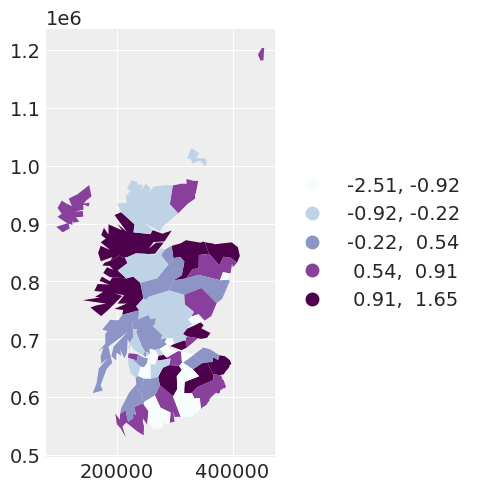

In [18]:
fixed_spatial_map = spat_df.plot(
    column="SPATIAL_RES",
    scheme="quantiles",
    k=5,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)},
)

If we wanted to be *fully Bayesian* about the model that we specify, we would estimate the spatial dependence parameter $\alpha$. This leads to ... 

### Our third model: a *spatial* random effects model, with unknown spatial dependence
The only difference between model 3 and model 2, is that in model 3, $\alpha$ is unknown, so we put a prior $\alpha \sim \text{Beta} \big (\alpha = 1, \beta=1\big )$ over it.

In [19]:
with pm.Model(coords={"area_idx": np.arange(N)}) as car_model:
    beta0 = pm.Normal("beta0", mu=0.0, tau=1.0e-5)
    beta1 = pm.Normal("beta1", mu=0.0, tau=1.0e-5)
    # variance parameter of the independent random effect
    tau_ind = pm.Gamma("tau_ind", alpha=3.2761, beta=1.81)
    # variance parameter of the spatially dependent random effects
    tau_spat = pm.Gamma("tau_spat", alpha=1.0, beta=1.0)

    # prior for alpha
    alpha = pm.Beta("alpha", alpha=1, beta=1)

    # area-specific model parameters
    # independent random effect
    theta = pm.Normal("theta", mu=0, tau=tau_ind, dims="area_idx")
    # spatially dependent random effect
    phi = pm.CAR("phi", mu=np.zeros(N), tau=tau_spat, alpha=alpha, W=adj_matrix, dims="area_idx")

    # exponential of the linear predictor -> the mean of the likelihood
    mu = pm.Deterministic("mu", pt.exp(logE + beta0 + beta1 * x + theta + phi), dims="area_idx")

    # likelihood of the observed data
    y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx")

    # sampling the model
    car_idata = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_ind, tau_spat, alpha, theta, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.


We can plot the marginal posterior for $\alpha$, and see that it is very near $1$, suggesting strong levels of spatial dependence.

array([[<AxesSubplot: title={'center': 'alpha'}>]], dtype=object)

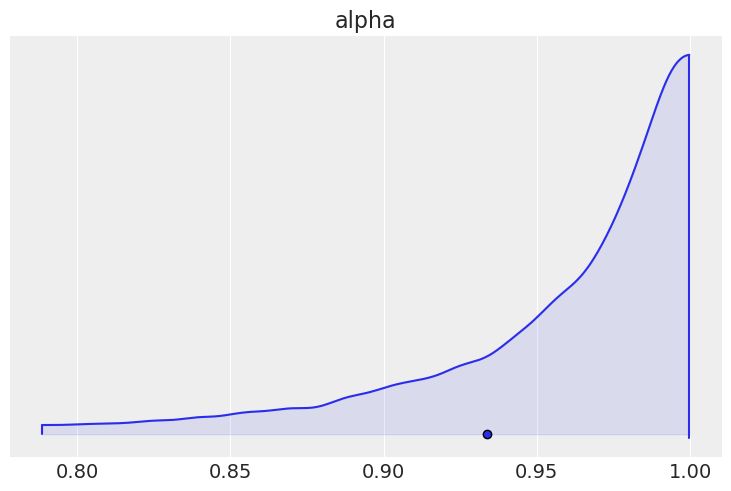

In [20]:
az.plot_density([car_idata], var_names=["alpha"], shade=0.1)

Comparing the regression parameters $\beta_0$ and $\beta_1$ between the three models that we have fit, we can see that accounting for the spatial dependence between observations has the ability to greatly impact the interpretation of the effect of covariates on the response variable.

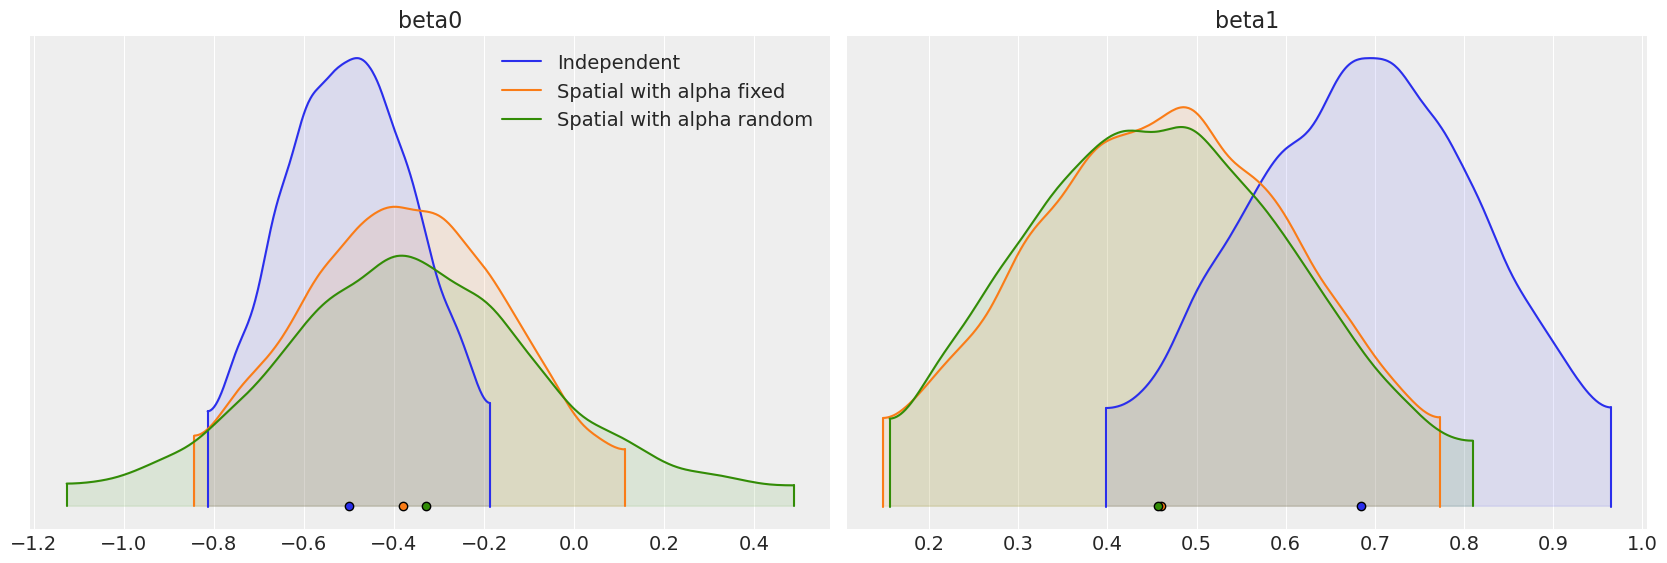

In [21]:
beta_density = az.plot_density(
    [independent_idata, fixed_spatial_idata, car_idata],
    data_labels=["Independent", "Spatial with alpha fixed", "Spatial with alpha random"],
    var_names=["beta0", "beta1"],
    shade=0.1,
)

## Limitations

Our final model provided some evidence that the spatial dependence parameter might be $1$. However, in the definition of the CAR prior, $\alpha$ can only take on values up to and excluding $1$. If $\alpha = 1$, we get an alternate prior called the *intrinsic conditional autoregressive (ICAR)* prior. The ICAR prior is more widely used in spatial models, specifically the BYM {cite:p}`besag1991bayesian`, Leroux {cite:p}`leroux2000estimation` and BYM2 {cite:p}`riebler2016intuitive` models. It also scales efficiently with large datasets, a limitation of the CAR distribution. Currently, work is being done to include the ICAR prior within PyMC.

## Authors

* Adapted from {ref}`another PyMC example notebook <conditional_autoregressive_model>` by Conor Hassan ([pymc-examples#417](https://github.com/pymc-devs/pymc-examples/pull/417)) and Daniel Saunders ([pymc-examples#547](https://github.com/pymc-devs/pymc-examples/pull/547/)).

## References 

:::{bibliography}
:filter: docname in docnames 
:::

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Jun 05 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

xarray: 2022.12.0

pymc      : 5.0.1
pytensor  : 2.8.11
pandas    : 1.5.2
numpy     : 1.24.1
arviz     : 0.14.0
libpysal  : 4.7.0
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::